# Flight Condition Normalization 

Following the ideas from: [Remaining Useful Life Prediction of Aircraft Engines with Variable Length Input Sequences](https://papers.phmsociety.org/index.php/phmconf/article/view/3108) PHM2021 data challenge competition winner

**Note:** This script is used **only for development data** to train the
flight condition normalization model (nominal behavior estimation).

In [1]:
import os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import joblib
import torch
import torch.nn as nn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer,
)
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping, Checkpoint

from src.training.opcond_pipelines import EstimationPipeline,HealthIndexTransformer, OperCondResidualAggregator, to_float32
from src.models.networks.operating_condition_mlp import OperatingConditionMLP
from src.helpers.seed import set_global_seed

from experiment_config import DATA_NAME, SEED

## Configuration

In [2]:
# Paths
experiment_dir = Path('experiments')/DATA_NAME
opcond_dir = experiment_dir/'opcond'
checkpoint_dir = opcond_dir/'checkpoints'



opcond_cols = ["alt", "Mach", "TRA", "T2", "Fc", "pos"]
num_cols = ["alt", "Mach", "TRA", "T2", "pos"]
performance_cols = ["T48", "SmFan", "SmLPC", "SmHPC"]

unit_col = "unit"
cycle_col = "cycle"
hs_col = "hs"

device = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs(checkpoint_dir, exist_ok=True)

In [3]:
set_global_seed(SEED)

## 1. Load dataset

In [4]:
df = pd.read_csv(experiment_dir/'data_dev.csv',dtype={"Fc": str})
df.T

,0,1,2,3,4,5,6,7,8,9,...,425714,425715,425716,425717,425718,425719,425720,425721,425722,425723
index,0,10,20,30,40,50,60,70,80,90,...,4257117,4257127,4257137,4257147,4257157,4257167,4257177,4257187,4257197,4257207
alt,3002.0,3090.0,3175.0,3264.0,3354.0,3446.0,3535.0,3626.0,3720.0,3810.0,...,4192.0,4056.0,3908.0,3748.0,3600.0,3450.0,3300.0,3188.0,3082.0,3002.0
Mach,0.370377,0.375417,0.378819,0.382347,0.385623,0.389088,0.393561,0.3969,0.400176,0.403956,...,0.401499,0.399105,0.402066,0.397404,0.397152,0.395892,0.393624,0.398916,0.397908,0.398601
TRA,81.122467,77.782646,75.497513,75.409622,75.409622,75.497513,75.409622,75.409622,75.936958,75.936958,...,25.575991,25.575991,25.575991,25.575991,25.575991,25.575991,28.65214,28.827919,28.827919,28.827919
T2,521.900827,521.960009,521.908866,521.854105,521.779145,521.712999,521.740075,521.67288,521.591355,521.566526,...,519.960757,520.268203,521.048077,521.264558,521.789824,522.24057,522.609527,523.446407,523.756392,524.105744
T24,628.0411,625.3416,622.6899,622.5073,622.3998,622.3805,622.2912,622.1935,622.49725,622.5177,...,568.8363,569.21765,570.0263,570.34375,570.9132,571.4371,575.4109,576.4492,576.81586,577.2005
T30,1511.5419,1499.1039,1489.7327,1488.9518,1488.4963,1488.3755,1487.7314,1487.2959,1488.8253,1488.4734,...,1269.1794,1270.1172,1271.6013,1272.5171,1273.7612,1274.9071,1293.9227,1296.4122,1297.2013,1297.9438
T48,1927.0433,1900.6204,1885.4208,1884.0522,1883.2153,1883.0511,1881.7915,1880.9757,1884.5851,1883.3674,...,1478.4889,1479.4548,1481.3826,1482.1378,1483.9453,1485.148,1518.5696,1522.6123,1523.38,1524.1246
T50,1306.0411,1291.5933,1285.184,1284.1221,1283.2598,1282.7261,1281.6675,1280.8103,1282.3821,1281.0815,...,1119.8252,1120.7025,1122.0826,1122.9236,1124.3768,1125.3723,1138.8811,1141.088,1141.7404,1142.2815
P15,20.030745,19.835783,19.649864,19.613483,19.580275,19.552637,19.526718,19.494423,19.486761,19.462805,...,16.183638,16.248573,16.359455,16.422823,16.511343,16.594284,16.86782,16.989252,17.04839,17.104366


## Operation Condition Normalization Procedure

Learn $f: X\mapsto Y$ frp, the flight conditions $X$ to the sensor outputs/performance metrics $Y$

$X$ Consist of 6 features, 4 flight conditions, 
* flight mach number (mach)
* altitude (alt)
* throttle resolve angle (TRA) 
* total fan inlet temperature (T2)
* flight class, a categorical feature describing the  flight length(Fc)
* positional variable of time elapsed within the flight cycle (pos)

**Note:** The paper says 5 features but they enumerate 6. 

* Performance metrics: $T48$, $SmFan$, $SmLPC$, $SmHPC$

## Train

## OC normalization pipeline (learns nominal behavior)

In [5]:
input_dim = len(num_cols) + df["Fc"].nunique()
output_dim = len(performance_cols)

callbacks = [
    EarlyStopping(
        monitor="valid_loss",
        patience=10,
        threshold=1e-4,
    ),
	Checkpoint(
    monitor="valid_loss_best",
    f_params=str(checkpoint_dir/"best_model.pt"),
    f_optimizer=str(checkpoint_dir/"best_optimizer.pt"),
    f_history=str(checkpoint_dir/"history.json"),
    f_criterion=str(checkpoint_dir/"criterion.pt"),
)]

oc_net = NeuralNetRegressor(
    OperatingConditionMLP,
    module__input_dim=input_dim,
    module__output_dim=output_dim,
    max_epochs=100,
    lr=5e-4,
    optimizer=torch.optim.AdamW,
    optimizer__weight_decay=1e-3,
    criterion=nn.MSELoss,
    iterator_train__shuffle=True,
    device=device,
    callbacks=callbacks,
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["Fc"]),
    ],
    remainder="drop",   # or "passthrough" if needed
)

oc_pipe = Pipeline([
    ("preprocess", preprocess),
    ("to_float32", FunctionTransformer(to_float32)),
    ("mlp", oc_net),
])

In [6]:
residual_aggregator = OperCondResidualAggregator(
        oc_pipe=None,
        opcond_cols=opcond_cols,
        perform_cols=performance_cols,
        unit_col=unit_col,
        cycle_col=cycle_col,
    )
hi_transformer=HealthIndexTransformer(
        metrics=performance_cols,
        cycle_col=cycle_col,
        q_low=0.01,
        q_high=0.99,
        corr_thresh=0.6,
    )

full_pipe = EstimationPipeline(
    oc_pipe,
    residual_aggregator,
    hi_transformer,
    hs_col=hs_col,
)


In [7]:
full_pipe.fit(df)

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1   123219.8082     1756.8659     +  0.6039
      2     1061.0721      310.7019     +  0.5496
      3      202.0725       78.4544     +  0.5557
      4       56.0604       27.7284     +  0.5499
      5       27.1708       16.9251     +  0.5540
      6       18.5470       13.5217     +  0.5532
      7       14.3543       11.7918     +  0.6179
      8       11.8722       10.3865     +  0.5910
      9       10.0713        9.1269     +  0.5564
     10        8.2136        7.3234     +  0.5541
     11        5.8860        4.9434     +  0.5496
     12        4.2447        4.0829     +  0.5496
     13        3.4405        4.5279        0.5489
     14        2.9207        2.8250     +  0.6091
     15        2.3597        2.8037     +  0.5553
     16        2.0150        1.9132     +  0.5539
     17        1.7339        1.7248     +  0.5532
     18        1.5841        1.9549        0.5535


,oc_pipe,Pipeline(step...tart=False))])
,residual_aggregator,"OperCondResid...PC', 'SmHPC'])"
,hi_transformer,"HealthIndexTr...PC', 'SmHPC'])"
,hs_col,'hs'
,metrics,"['T48', 'SmFan', ...]"
,cycle_col,'cycle'
,q_low,0.01
,q_high,0.99
,corr_thresh,0.6
,range_thresh,0.6
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"


In [8]:
df_hi = full_pipe.transform(df)
full_pipe.prune_performances_by_range(df_hi)

## Save the pipeline 

In [9]:
joblib.dump(full_pipe, opcond_dir/"pipeline_best.joblib")

['experiments/DS06/opcond/pipeline_best.joblib']

## Load the pipeline

In [10]:
pipe: EstimationPipeline = joblib.load(opcond_dir/"pipeline_best.joblib")
pipe.set_bounds(df,q_low=0.01, q_high=0.99)

,oc_pipe,Pipeline(step...tart=False))])
,residual_aggregator,"OperCondResid...PC', 'SmHPC'])"
,hi_transformer,"HealthIndexTr...PC', 'SmHPC'])"
,hs_col,'hs'
,metrics,"['T48', 'SmFan', ...]"
,cycle_col,'cycle'
,q_low,0.01
,q_high,0.99
,corr_thresh,0.6
,range_thresh,0.6
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"


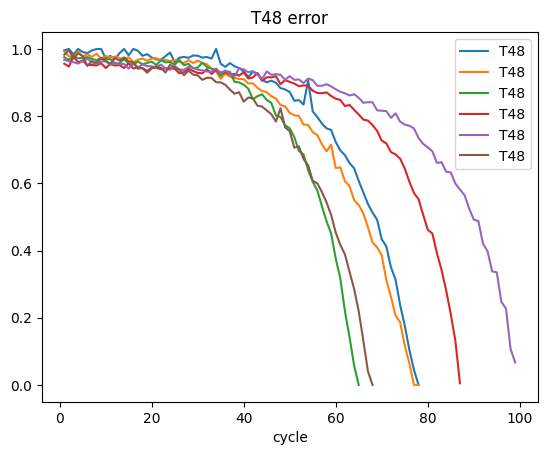

In [11]:
for perf in pipe.get_performances():
    fig, ax = plt.subplots()
    ax.set_title(f"{perf} error")
    df_hi.groupby("unit").plot(x="cycle", y=f'{perf}', ax=ax, legend=True)